In [1]:
%matplotlib inline

from modsim import *

In [3]:
def make_system(beta, gamma, death_rate):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0, D=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma, death_rate=death_rate)

In [14]:
def plot_results(S, I, R, D):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    plot(D, color='black', label="Dead")
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [ ]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [11]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for i in linrange(t0, t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
    
    system.results = frame
    return frame

In [4]:
def update1(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i, r, d = state

    infected = beta * i * s    
    recovered = gamma * i
    deaths = i * death_rate
    
    s -= infected
    i += infected - recovered - deaths
    r += recovered
    d += deaths
    
    return State(S=s, I=i, R=r, D=d)

0.041915473577421702

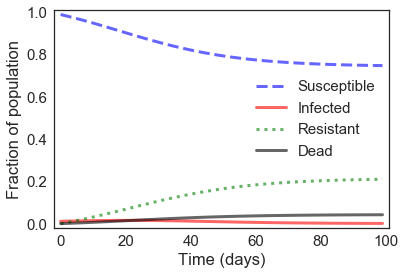

In [26]:
sird = make_system(0.333, 0.25, 0.05)
frame = run_simulation(sird, update1)

plot_results(frame.S, frame.I, frame.R, frame.D)
frame.D[sird.t_end]

0.030205325019757253

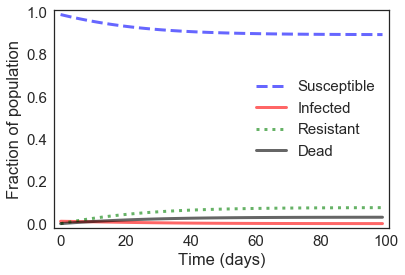

In [27]:
sird = make_system(0.333, 0.25, 0.1)
frame = run_simulation(sird, update1)

plot_results(frame.S, frame.I, frame.R, frame.D)
frame.D[sird.t_end]

0.016598022988869483

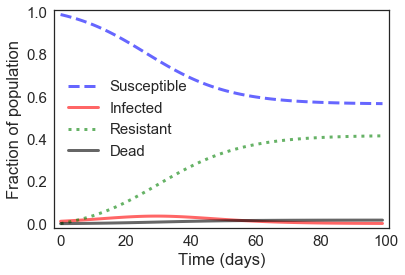

In [28]:
sird = make_system(0.333, 0.25, 0.01)
frame = run_simulation(sird, update1)

plot_results(frame.S, frame.I, frame.R, frame.D)
frame.D[sird.t_end]

0.01206683981192856

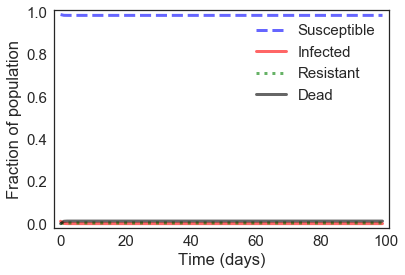

In [25]:
sird = make_system(0.333, 0.25, 1)
frame = run_simulation(sird, update1)

plot_results(frame.S, frame.I, frame.R, frame.D)
frame.D[sird.t_end]

In [29]:
def sweep_death(death_array):
    sweep = SweepSeries()
    for d in death_array:
        sird = make_system(0.333, 0.25, d)
        frame = run_simulation(sird, update1)
        sweep[d] = frame.D[t_end]
    return sweep

AttributeError: Unknown property xlabel

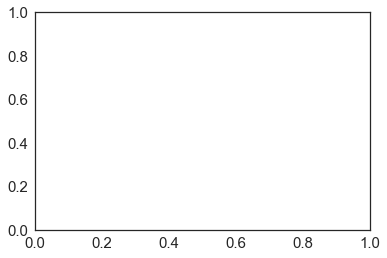

In [32]:
death_array = linspace(0, 0.2, 21)
sweep = sweep_death(death_array)
plot(sweep, xlabel = 'Death Rate', ylabel = 'Fraction Dead')
print(idxmax(sweep))